In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# import pytorch nn libraries 
import torch 
import torch.nn as nn

# import image processing tools 
import torchvision
import torchvision.transforms as transforms
import cv2
from skimage.transform import resize
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import label, regionprops, regionprops_table
from scipy.ndimage import binary_fill_holes

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Image processsing for Melanoma Kaggle Competition

This notebook explores the training dataset and puts together a training strategy for the Kaggle hosted SIIM-ISIC melanoma classification competition. 

In [2]:
# upload train dataframe
train_df_allsamples = pd.read_csv("../../data-256/train.csv")
train_df_allsamples.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [3]:
# create dictionary that maps image name to target 
image_names = train_df_allsamples["image_name"].values 
targets = train_df_allsamples["target"].values
img_to_target = {image_name:target for image_name, target in zip(image_names, targets)}

percent_tp = sum(targets)/len(targets) * 100 
print("{} training samples total.".format(len(targets)))
print("Only {:.3f} percent of training data set is a positive.".format(percent_tp))
print("Baseline accuracy is {:.3f}".format(np.max([percent_tp, 100-percent_tp])))

33126 training samples total.
Only 1.763 percent of training data set is a positive.
Baseline accuracy is 98.237


# Start by trying to display an image from training set 

image shape: 
(256, 256, 3)

 image is malignant?: 0


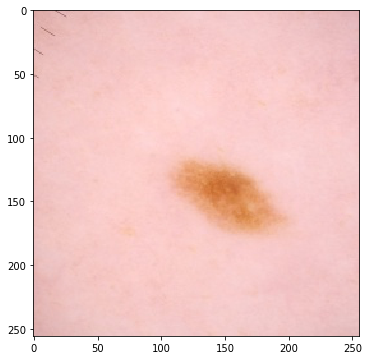

In [4]:
# specify path to training data  
train_path = "../../data-256/train/"

# load all training files
train_files = [s+".jpg" for s in train_df_allsamples["image_name"].values]

# pull an example 
img_ind = 23
example = train_path + train_files[img_ind]
img_name = train_files[img_ind].split(".")[0]
img = plt.imread(example)
print("image shape: ")
print(img.shape)
print("\n image is malignant?: {}".format(img_to_target[img_name]))

# display 
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.show()

# Image pre-processing

Need image preprocessing steps to: 

1. Isolate the melanoma and crop image 
2. Ensure cropped images are a consistent size for input to CNN 

Follow steps from last year's winning model: https://www.sciencedirect.com/science/article/pii/S2215016120300832?via%3Dihub

1. Binarize image
2. Determine regions likely to have imaged skin lesion
3. Apply a "shades of grey" color constancy filter 

In [5]:
# color constancy (function originally designed by https://github.com/JiaxinZhuang/Skin-Lesion-Recognition.Pytorch)
def shade_of_gray_cc(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)


def im_filter(img):
    # use shade of grey 
    img = shade_of_gray_cc(img)
    
    # grayscale and blur img 
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = gaussian(img_gray, 3)
    
    # determine binarization level 
    lvl = threshold_otsu(img_blur) 
    
    # binarize image 
    img_bin = np.ones(img_gray.shape)
    img_bin[img_blur > lvl] = 0
    img_filled = binary_fill_holes(img_bin)
    return label(img_filled)

# function to crop image 
def crop(img, imsize=256, margin=.5):
    label_img = im_filter(img)
    [n, m] = label_img.shape
    stats = regionprops(label_img)
    
    # get diamter and center of im
    axis_lengths = []
    centroids = []
    for stat in stats:
        axis_lengths.append(np.atleast_2d([stat.minor_axis_length, stat.major_axis_length]))
        centroids.append(np.atleast_2d(stat.centroid))
    diameters = np.mean(np.concatenate(axis_lengths, axis=0), 1)
    centroids = np.concatenate(centroids, axis=0)
    
    inds = np.argsort(diameters)[::-1]
    radius = diameters[inds[0]] / 2 
    center = centroids[inds[0], :]
    
    x_min = np.int(center[0]-radius-margin*radius)
    x_max = np.int(center[0]+radius+margin*radius)
    y_min = np.int(center[1]-radius-margin*radius)
    y_max = np.int(center[1]+radius+margin*radius)
    
    if (x_min < 0 or x_max > n or y_min < 0 or y_max > m) and len(inds) > 1:
        # use second largest diameter 
        radius = diameters[inds[1]] / 2 
        center = centroids[inds[1], :]

        x_min = np.int(center[0]-radius-margin*radius)
        x_max = np.int(center[0]+radius+margin*radius)
        y_min = np.int(center[1]-radius-margin*radius)
        y_max = np.int(center[1]+radius+margin*radius)

        if x_min < 0 or x_max > n or y_min < 0 or y_max > m:
            # give up
            img_resize = cv2.resize(img, (imsize, imsize), interpolation = cv2.INTER_AREA)
            return img_resize
        
    # look at ratio of pixel intensity inside and outside of cropped image 
    mean_inside = np.mean(img[x_min:x_max, y_min:y_max, :]) 
    mean = np.mean(img)
    if mean_inside / mean < .5:
        # give up
        print(mean_inside / mean)
        img_resize = cv2.resize(img, (imsize, imsize), interpolation = cv2.INTER_AREA)
        return img_resize
    
    # resize image to be 
    img_cropped = img[x_min:x_max, y_min:y_max, :]
    img_resize = cv2.resize(img_cropped, (imsize, imsize), interpolation = cv2.INTER_CUBIC)
    
    return img_resize

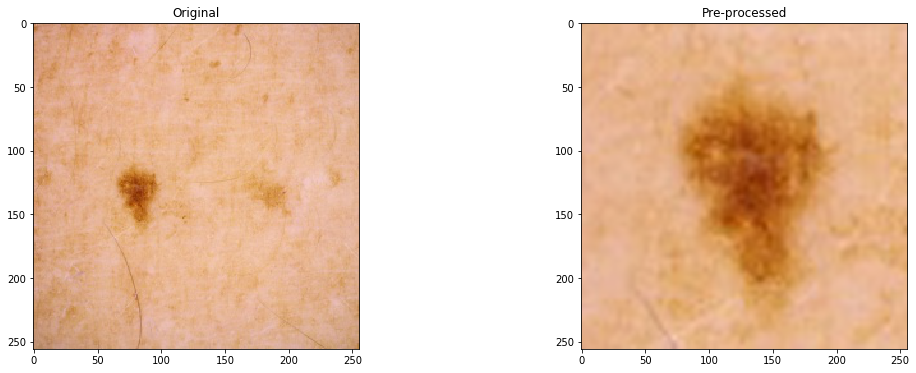

In [6]:
# pull an example 
img_ind = 1
example = train_path + train_files[img_ind]
img_name = train_files[img_ind].split(".")[0]
img = plt.imread(example)

# display 
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(crop(img))
plt.title("Pre-processed")

plt.show()

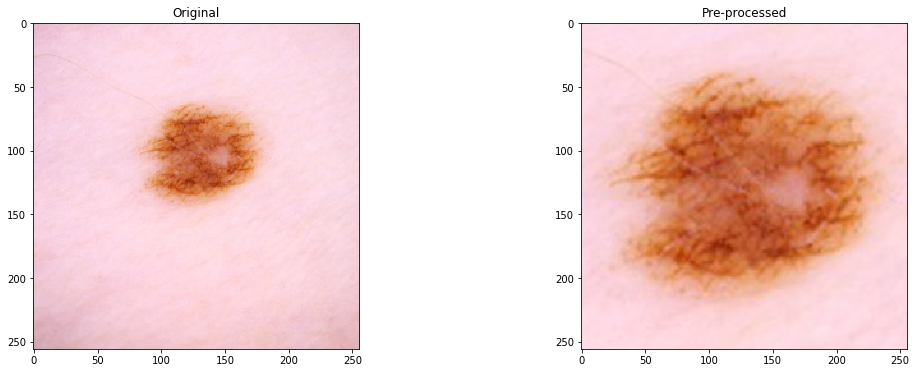

In [7]:
# pull an example 
img_ind = 5
example = train_path + train_files[img_ind]
img_name = train_files[img_ind].split(".")[0]
img = plt.imread(example)

# display 
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(crop(img))
plt.title("Pre-processed")

plt.show()

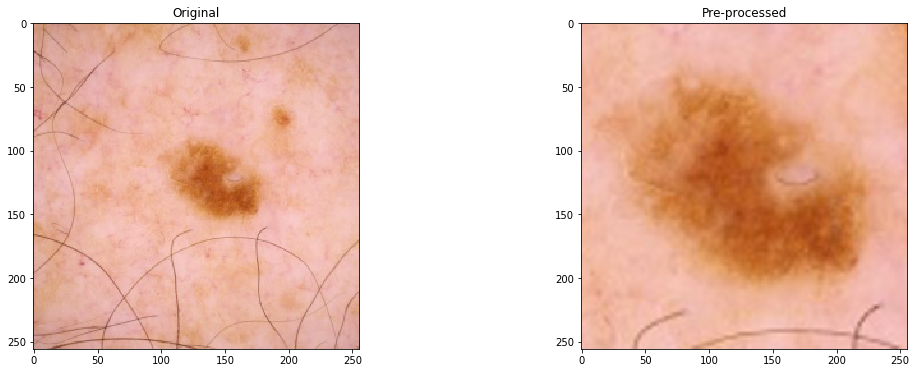

In [8]:
# pull an example 
img_ind = 11
example = train_path + train_files[img_ind]
img_name = train_files[img_ind].split(".")[0]
img = plt.imread(example)

# display 
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(crop(img))
plt.title("Pre-processed")

plt.show()